# DLG Assignment 2

### Submitted by:
- Namita Achyuthan: PES1UG22AM100
- Shusrith S: PES1UG22AM155
- Siddhi Zanwar: PES1UG22AM161

##### * Detailed assignment report available [here](https://docs.google.com/document/d/1etideCaU4pXN6Vzvw4E2q9FvwdNfgt0YcsWTcFIjKDw/edit?usp=sharing)

In [2]:
! pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.7 MB/s eta 0:00:00


In [87]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.nn import HypergraphConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tqdm import tqdm
import numpy as np
import networkx as nx
import torch
import math
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

## Dataset Overview and Preprocessing

We began our exploration by examining the four provided files: `train_stock_data.csv`, `validation_stock_data.csv`, `hyperedges.json`, and `bling_test_cases.json`. The training and validation datasets contained **20,160** and **2,000** entries, respectively. The `hyperedges.json` file described **eight hyperedges**, and there were **120 test cases** in `bling_test_cases.json`.

Upon inspecting the training dataset, we found **20 unique tickers**, each represented by five attributes: **Open, Close, Volume, High, and Low**. This resulted in a sparse structure with **102 columns**. We decoded the hypergraph and assigned numerical identifiers to each ticker for easier referencing.

We encountered an issue with the **date format**, which was inconsistent. We resolved this by applying Pandas' `to_datetime` function and sorting by ticker and date. To enhance interpretability, we transformed the data into a more conventional time-series format with clear columns: **Date, Ticker, Open, High, Low, Close, and Volume**.

Visualizing the data revealed significant variations across companies, prompting us to consider **normalization techniques**. We tested three primary scaling methods:  
- **Standard Scaler**: Removes the mean and scales to unit variance.
- **Min-Max Scaler**: Scales features to a given range, typically between 0 and 1.
- **Robust Scaler**: Uses the median and interquartile range, making it less sensitive to outliers.



We ended up choosing the robust scaler since it gave us the least MAPE upon model evaluation.


---

At this stage, we had completed the foundational preprocessing steps, marking the point where our approaches began to diverge for downstream experimentation.

In [4]:
train_data = pd.read_csv('/content/DLG-Assignments/ASSignment2/train_stock_data.csv')
train_data['Date'] = pd.to_datetime(train_data['Date'], format='%Y-%m-%d') # date is a string make it a datetime obj
train_data.sort_values(['Ticker', 'Date'], inplace=True) # sort the ticker by date

In [5]:
validation_data = pd.read_csv('/content/DLG-Assignments/ASSignment2/validation_stock_data.csv')
validation_data['Date'] = pd.to_datetime(validation_data['Date'], format='%Y-%m-%d')
validation_data.sort_values(['Ticker', 'Date'], inplace=True)

In [6]:
with open('/content/DLG-Assignments/ASSignment2/hyperedges.json', 'r') as f:
    hyperedges = json.load(f) # load the hyperedge defintions

In [7]:
with open('/content/DLG-Assignments/ASSignment2/blind_test_cases.json', 'r') as f:
    test_cases = json.load(f)

In [8]:
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {validation_data.shape}")
print(f"Number of hyperedges: {len(hyperedges)}")
print(f"Number of test cases: {len(test_cases)}")
print("Available tickers in training data:", train_data['Ticker'].unique())

Training data shape: (20160, 102)
Validation data shape: (2000, 102)
Number of hyperedges: 8
Number of test cases: 120
Available tickers in training data: ['AAPL' 'AMZN' 'BA' 'BAC' 'C' 'CAT' 'CVX' 'DUK' 'GOOGL' 'JNJ' 'JPM' 'KO'
 'MRK' 'MSFT' 'PFE' 'PG' 'T' 'VZ' 'WMT' 'XOM']


In [9]:
l = []  # Initialize an empty list to store preprocessed rows

tickers = train_data['Ticker'].unique()  # Get a list of unique tickers

for ticker in tickers:
    data = train_data[train_data["Ticker"] == ticker]  # Filter data for the current ticker

    valid_cols = []  # List to store columns without missing values

    for i in data.columns:
        if data[i].isna().sum() == 0:  # Check if the column has no NaN values
            valid_cols.append(i)  # Add it to the valid columns list

    a = data[valid_cols].values  # Extract only the valid columns as a numpy array

    for i in a:
        l.append(i)  # Add each row to the final preprocessed list

# Convert the list of clean rows into a DataFrame with proper column names
df = pd.DataFrame(l, columns=["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"])

In [10]:
df['Return'] = df.groupby('Ticker')['Close'].pct_change() # percentage change in closing price (i am finance bro now)
df['Volatility'] = df.groupby('Ticker')['Return'].rolling(window=30).std().reset_index(0, drop=True) # 30 day window for rolling volatility
df['Momentum'] = df.groupby('Ticker')['Close'].pct_change(periods=5) # 5 day momentum (price change)
df['Moving_Avg'] = df.groupby('Ticker')['Close'].rolling(window=30).mean().reset_index(0, drop=True)
df.fillna(0, inplace=True) # if nan make 0

In [11]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'Volatility', 'Momentum', 'Moving_Avg']

In [12]:
# scaler = StandardScaler()
# scaler = MinMaxScaler() # loss was 52354522137231.3594 gg
scaler = RobustScaler() # Val Loss: 0.1693
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [13]:
# ticker to index mapping
sorted_tickers = sorted(tickers) # first sort alphabetically
ticker_to_idx = {ticker: idx for idx, ticker in enumerate(sorted_tickers)} # dict mapping
print("Ticker to index mapping:", ticker_to_idx)

Ticker to index mapping: {'AAPL': 0, 'AMZN': 1, 'BA': 2, 'BAC': 3, 'C': 4, 'CAT': 5, 'CVX': 6, 'DUK': 7, 'GOOGL': 8, 'JNJ': 9, 'JPM': 10, 'KO': 11, 'MRK': 12, 'MSFT': 13, 'PFE': 14, 'PG': 15, 'T': 16, 'VZ': 17, 'WMT': 18, 'XOM': 19}


## HGNN Model

### What is a HGNN?  
A Hypergraph Neural Network (HGNN) is a graph neural network designed for hypergraphs, where a single hyperedge can connect multiple nodes (unlike traditional graphs that connect only two). This makes HGNNs ideal for modeling higher-order relationships. In our context, stocks are nodes, and industries (like Tech and Healthcare) are hyperedges, connecting all stocks within a sector to capture sector-wise dependencies.

### Why HGNN?  
We chose HGNN because:  
- Sector Influence: Stocks in the same industry often respond similarly to economic or political trends.  
- Beyond Pairwise Modeling: Standard GNNs capture only pairwise relationships, while HGNNs model multi-node interactions via shared hyperedges.  
- Rich Contextual Learning: HGNNs excel at capturing sector-level co-movements and dependencies, essential for financial prediction tasks.  

The incidence matrix ensures industries share information within their hyperedges, leveraging HGNN's strength in higher-order reasoning.

---

### Implementation Overview  
#### Data Structure Preparation:  
- Nodes: Represent individual stocks.  
- Hyperedges: Connect stocks within the same industry to model group dynamics.  
- An incidence matrix encodes multi-node connectivity using `hyperedge_index`.  

#### Graph Snapshots (Temporal View):  

For each trading date:  
- Node features: Stock indicators like returns and volatility.  
- Node targets: Actual prices (Open, High, Low, Close, Volume).  

These snapshots are wrapped as `torch_geometric.data.Data` objects with consistent `hyperedge_index`.

#### Model Architecture:  
The model uses two stacked Hypergraph Convolutional Layers:  
1. The first layer transforms features into rich representations using ELU activation.  
2. The second layer outputs continuous values for the five price attributes.

#### Training Setup:  
- Loss function: Mean Squared Error (MSE).  
- Optimizer: Adam with learning rate scheduling for steady convergence.  
- Metrics: Root Mean Squared Error (RMSE) and Mean Absolute Percentage Error (MAPE).

### Temporal Handling and Attention Mechanisms  
The model treats time as independent static graph snapshots rather than explicitly modeling temporal dependencies (like RNNs or Transformers). Each snapshot captures day-wise spatial dependencies among stocks via hyperedges. Information is aggregated using uniform weights without learnable attention mechanisms over neighbors or hyperedges.

In [14]:
# node to hyperedge maps (incidence matrix)
num_nodes = len(sorted_tickers) # number of stocks (nodes)
num_hyperedges = len(hyperedges) # number of hyperedges (industry)

In [15]:
# Create node-to-hyperedge incidence matrix
# For HypergraphConv we need:
# 1. hyperedge_index: list of [node_idx, hyperedge_idx] pairs
# 2. hyperedge_weight: weight for each hyperedge
# gpt helped here big time

hyperedge_index = [] # pairs of node_index, hyperedge_index
for he_idx, (he_name, he_tickers) in enumerate(hyperedges.items()):
    for ticker in he_tickers:
        node_idx = ticker_to_idx[ticker] # get node index frmo tivker
        hyperedge_index.append([node_idx, he_idx]) # add connection between node and hyperedge

In [16]:
hyperedge_index = torch.tensor(hyperedge_index, dtype=torch.long).t() # transpose for 2*N tensor
hyperedge_weight = torch.ones(num_hyperedges, dtype=torch.float) # all hyperedges get weight 1

In [17]:
# double check
print(f"Hyperedge index shape: {hyperedge_index.shape}")
print(f"Hyperedge weight shape: {hyperedge_weight.shape}")

Hyperedge index shape: torch.Size([2, 20])
Hyperedge weight shape: torch.Size([8])


In [18]:
def get_features_for_date(df, date, tickers, feature_cols):
    day_df = df[df['Date'] == date].set_index('Ticker') # filter data fr given date
    day_df = day_df.reindex(tickers)
    x = day_df[feature_cols].fillna(0).values
    y = day_df[['Open', 'High', 'Low', 'Close', 'Volume']].fillna(0).values # target (output)
    return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

In [19]:
# make each date a snapshot of the graph
dates = sorted(df['Date'].unique())
graph_snapshots = []
for date in dates:
    x_t, y_t = get_features_for_date(df, date, sorted_tickers, features)
    graph_snapshots.append((x_t, y_t))

In [20]:
# graph objects for pytorch geo
train_graphs = []
for x_t, y_t in graph_snapshots:
    # DATA OBJECT with node features, hyperedge
    graph = Data(x=x_t, hyperedge_index=hyperedge_index, hyperedge_attr=hyperedge_weight, y=y_t)
    train_graphs.append(graph)

In [21]:
l_val = []
val_tickers = sorted(validation_data['Ticker'].unique())
for ticker in val_tickers:
    data = validation_data[validation_data["Ticker"] == ticker] # basically since 8 in the val and 20 in the train, you match the ticker in val to the one in train
    # nice
    valid_cols = []
    for i in data.columns:
        if data[i].isna().sum() == 0:
            valid_cols.append(i)
    a = data[valid_cols].values
    for i in a:
        l_val.append(i)
df_val = pd.DataFrame(l_val, columns=["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"])

In [22]:
df_val['Return'] = df_val.groupby('Ticker')['Close'].pct_change()
df_val['Volatility'] = df_val.groupby('Ticker')['Return'].rolling(window=30).std().reset_index(0, drop=True)
df_val['Momentum'] = df_val.groupby('Ticker')['Close'].pct_change(periods=5)
df_val['Moving_Avg'] = df_val.groupby('Ticker')['Close'].rolling(window=30).mean().reset_index(0, drop=True)
df_val.fillna(0, inplace=True)

In [23]:
# normalize
df_val[feature_cols] = scaler.transform(df_val[feature_cols])

In [24]:
val_dates = sorted(df_val['Date'].unique())
val_graph_snapshots = []
for date in val_dates:
    x_t, y_t = get_features_for_date(df_val, date, sorted_tickers, features)
    val_graph_snapshots.append((x_t, y_t))

In [25]:
val_graphs = []
for x_t, y_t in val_graph_snapshots:
    graph = Data(x=x_t, hyperedge_index=hyperedge_index, hyperedge_attr=hyperedge_weight, y=y_t)
    val_graphs.append(graph)

In [26]:
class StockHGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=5):
        super().__init__() # parent class
        # first hypergraph convolution layer: input_features -> hidden_features
        self.hgconv1 = HypergraphConv(in_channels, hidden_channels)

        # second hypergraph convolution layer: hidden_features -> output_features
        self.hgconv2 = HypergraphConv(hidden_channels, out_channels)

    def forward(self, x, hyperedge_index, hyperedge_weight=None):
        # apply first layer with ELU activation function
        x = F.elu(self.hgconv1(x, hyperedge_index, hyperedge_weight))

        # next is applying second layer (no activation for regression output)
        x = self.hgconv2(x, hyperedge_index, hyperedge_weight)
        return x

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StockHGNN(in_channels=len(features), hidden_channels=32, out_channels=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
loss_fn = torch.nn.MSELoss() # cuz regressuion
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [28]:
train_loader = DataLoader(train_graphs, batch_size=1, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=1, shuffle=False)

In [29]:
hyperedge_index = hyperedge_index.to(device)
hyperedge_weight = hyperedge_weight.to(device)

In [30]:
epochs = 50
train_losses, val_losses = [], []

In [31]:
for epoch in range(epochs):
    # Training
    model.train() # set to training mode
    train_loss = 0
    for batch in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training", leave=False):
        batch = batch.to(device) # bacth data to devoce
        optimizer.zero_grad() # clear prev gradients
        out = model(batch.x, batch.hyperedge_index, batch.hyperedge_attr) # forward pass
        loss = loss_fn(out, batch.y) # get the loss
        loss.backward() # back prop
        optimizer.step() # update weights
        train_loss += loss.item() # accumulate loss
    train_loss /= len(train_loader) # avg loss
    train_losses.append(train_loss) # store for when we plot

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"[Epoch {epoch+1}] Validation", leave=False):
            batch = batch.to(device)
            out = model(batch.x, batch.hyperedge_index, batch.hyperedge_attr)
            loss = loss_fn(out, batch.y)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1 | Train Loss: 53.8344 | Val Loss: 0.5234


Epoch 2 | Train Loss: 0.6554 | Val Loss: 0.5788


Epoch 3 | Train Loss: 0.4424 | Val Loss: 0.4285


Epoch 4 | Train Loss: 0.3575 | Val Loss: 0.4316


Epoch 5 | Train Loss: 0.3454 | Val Loss: 0.4080


Epoch 6 | Train Loss: 0.3409 | Val Loss: 0.3760


Epoch 7 | Train Loss: 0.3386 | Val Loss: 0.3564


Epoch 8 | Train Loss: 0.3368 | Val Loss: 0.3185


Epoch 9 | Train Loss: 0.3350 | Val Loss: 0.2708


Epoch 10 | Train Loss: 0.3329 | Val Loss: 0.2475


Epoch 11 | Train Loss: 0.3314 | Val Loss: 0.2192


Epoch 12 | Train Loss: 0.3304 | Val Loss: 0.2059


Epoch 13 | Train Loss: 0.3300 | Val Loss: 0.1968


Epoch 14 | Train Loss: 0.3298 | Val Loss: 0.1893


Epoch 15 | Train Loss: 0.3296 | Val Loss: 0.1870


Epoch 16 | Train Loss: 0.3294 | Val Loss: 0.1833


Epoch 17 | Train Loss: 0.3293 | Val Loss: 0.1813


Epoch 18 | Train Loss: 0.3292 | Val Loss: 0.1772


Epoch 19 | Train Loss: 0.3291 | Val Loss: 0.1764


Epoch 20 | Train Loss: 0.3291 | Val Loss: 0.1742


Epoch 21 | Train Loss: 0.3290 | Val Loss: 0.1730


Epoch 22 | Train Loss: 0.3290 | Val Loss: 0.1720


Epoch 23 | Train Loss: 0.3290 | Val Loss: 0.1716


Epoch 24 | Train Loss: 0.3290 | Val Loss: 0.1713


Epoch 25 | Train Loss: 0.3289 | Val Loss: 0.1707


Epoch 26 | Train Loss: 0.3289 | Val Loss: 0.1707


Epoch 27 | Train Loss: 0.3289 | Val Loss: 0.1702


Epoch 28 | Train Loss: 0.3289 | Val Loss: 0.1700


Epoch 29 | Train Loss: 0.3289 | Val Loss: 0.1697


Epoch 30 | Train Loss: 0.3289 | Val Loss: 0.1696


Epoch 31 | Train Loss: 0.3289 | Val Loss: 0.1695


Epoch 32 | Train Loss: 0.3289 | Val Loss: 0.1695


Epoch 33 | Train Loss: 0.3289 | Val Loss: 0.1695


Epoch 34 | Train Loss: 0.3288 | Val Loss: 0.1695


Epoch 35 | Train Loss: 0.3289 | Val Loss: 0.1693


Epoch 36 | Train Loss: 0.3289 | Val Loss: 0.1692


Epoch 37 | Train Loss: 0.3288 | Val Loss: 0.1693


Epoch 38 | Train Loss: 0.3288 | Val Loss: 0.1694


Epoch 39 | Train Loss: 0.3288 | Val Loss: 0.1693


Epoch 40 | Train Loss: 0.3288 | Val Loss: 0.1692


Epoch 41 | Train Loss: 0.3288 | Val Loss: 0.1691


Epoch 42 | Train Loss: 0.3288 | Val Loss: 0.1692


Epoch 43 | Train Loss: 0.3288 | Val Loss: 0.1693


Epoch 44 | Train Loss: 0.3288 | Val Loss: 0.1691


Epoch 45 | Train Loss: 0.3288 | Val Loss: 0.1691


Epoch 46 | Train Loss: 0.3288 | Val Loss: 0.1691


Epoch 47 | Train Loss: 0.3288 | Val Loss: 0.1691


Epoch 48 | Train Loss: 0.3288 | Val Loss: 0.1691


Epoch 49 | Train Loss: 0.3288 | Val Loss: 0.1691


Epoch 50 | Train Loss: 0.3288 | Val Loss: 0.1692


In [32]:
model.eval() # now set model to evaluation mode
preds_list, actuals_list = [], []
with torch.no_grad(): # no gradient evaluation
    for batch in tqdm(val_loader, desc="Making Predictions", leave=False):
        batch = batch.to(device)
        preds = model(batch.x, batch.hyperedge_index, batch.hyperedge_attr)
        preds_list.append(preds.cpu()) # store preds
        actuals_list.append(batch.y.cpu()) # store actual values

In [33]:
preds = torch.cat(preds_list, dim=0)
actuals = torch.cat(actuals_list, dim=0)

In [34]:
# kick out zero values
mask = actuals.abs().sum(dim=1) > 0  # mask for non-zero rows
preds = preds[mask].numpy()  # Apply mask  like we all do in life
actuals = actuals[mask].numpy()

In [35]:
rmse = np.sqrt(mean_squared_error(actuals, preds))
mape = np.mean(np.abs((actuals - preds) / np.clip(np.abs(actuals), 1e-10, None))) * 100

In [36]:
pred_df = pd.DataFrame(preds, columns=["Open", "High", "Low", "Close", "Volume"])
actual_df = pd.DataFrame(actuals, columns=["Open", "High", "Low", "Close", "Volume"])

In [37]:
# scale back up now
#copies for the inverse-transformed data
pred_df_og = pred_df.copy()
actual_df_og = actual_df.copy()

In [38]:
pred_df_og[feature_cols] = scaler.inverse_transform(pred_df[feature_cols])
actual_df_og[feature_cols] = scaler.inverse_transform(actual_df[feature_cols])

In [39]:
og_rmse = np.sqrt(mean_squared_error(actual_df_og, pred_df_og))
og_mape = np.mean(np.abs((actual_df_og - pred_df_og) / np.clip(np.abs(actual_df_og), 1e-10, None))) * 100
print(f"Original Scale RMSE: {og_rmse:.4f}")
print(f"Original Scale MAPE: {og_mape:.2f}%")

Original Scale RMSE: 5985826.6522
Original Scale MAPE: 34.82%


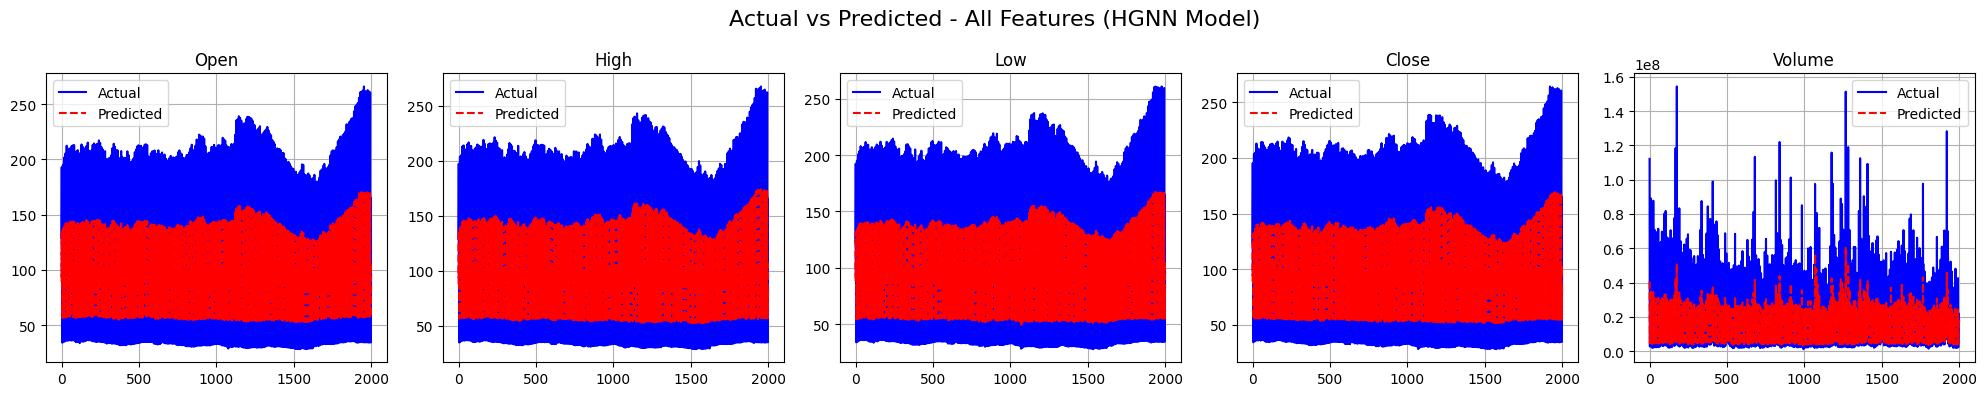

In [91]:
column_names = pred_df_og.columns.tolist()
fig, axs = plt.subplots(1, len(column_names), figsize=(20, 4), sharex=True)
for i, col in enumerate(column_names):
    axs[i].plot(actual_df_og[col], label="Actual", color="blue")
    axs[i].plot(pred_df_og[col], label="Predicted", color="red", linestyle='dashed')
    axs[i].set_title(f"{col}")
    axs[i].legend()
    axs[i].grid(True)

fig.suptitle("Actual vs Predicted - All Features (HGNN Model)", fontsize=16)
plt.tight_layout()
plt.show()

## GAT

### What is a GAT?  
A Graph Attention Network (GAT) is a type of neural network designed for graph-structured data. It improves upon traditional Graph Neural Networks (GNNs) by introducing an attention mechanism, which learns to weigh the importance of different nodes (or neighbors) during message-passing. Unlike standard GNNs that treat all neighbors equally, GATs focus more on relevant connections, enabling better aggregation of node information.

### Why GAT?  
We chose GAT for our stock hypergraph because:  
- Heterogeneous Relationships: In financial graphs, the influence of one stock on another varies over time. GAT’s attention mechanism adapts to these dynamic relationships.  
- Improved Accuracy: By emphasizing stronger connections, GAT captures nuanced dependencies, enhancing prediction performance.  

---

### Implementation Overview  
#### Model Architecture:  
- Two stacked GATConv layers:  
  - The first layer applies attention-based message passing to learn node embeddings.  
  - The second layer refines these embeddings.  
- Activation: ReLU is applied after the second layer.  
- Global Mean Pooling: Aggregates node-level information into a graph-level representation.  
- Fully Connected Layer: Performs classification based on pooled embeddings.

#### Temporal Handling and Attention Mechanism:  
- Self-Attention: Nodes learn to weigh their neighbors differently using attention coefficients, enabling localized focus on informative connections.  
- Unlike temporal models (e.g., RNNs), GAT operates on static graph snapshots, learning spatial relationships independently for each snapshot.

This setup allows the model to capture both local node-wise dependencies and holistic graph-level dynamics without introducing complex temporal layers.


In [42]:
hyperedge_indices = []
for he_name, ticker in hyperedges.items():
    indices = [ticker_to_idx[t] for t in ticker]
    print(f"Hyperedge '{he_name}': {ticker} -> {indices}")
    hyperedge_indices.append(indices)

Hyperedge 'Tech': ['AAPL', 'GOOGL', 'MSFT', 'AMZN'] -> [0, 8, 13, 1]
Hyperedge 'Finance': ['JPM', 'BAC', 'C'] -> [10, 3, 4]
Hyperedge 'Healthcare': ['JNJ', 'PFE', 'MRK'] -> [9, 14, 12]
Hyperedge 'Energy': ['XOM', 'CVX'] -> [19, 6]
Hyperedge 'Consumer': ['WMT', 'PG', 'KO'] -> [18, 15, 11]
Hyperedge 'Industrials': ['BA', 'CAT'] -> [2, 5]
Hyperedge 'Communications': ['VZ', 'T'] -> [17, 16]
Hyperedge 'Utilities': ['DUK'] -> [7]


In [43]:
hyperedge_indices

[[0, 8, 13, 1],
 [10, 3, 4],
 [9, 14, 12],
 [19, 6],
 [18, 15, 11],
 [2, 5],
 [17, 16],
 [7]]

In [44]:
# clique representation
adj_matrix = [[0 for i in range(20)] for j in range(20)]
for hyperedge in hyperedge_indices:
    for i in range(len(hyperedge)):
        for j in range(i+1, len(hyperedge)):
            adj_matrix[hyperedge[i]][hyperedge[j]] = 1
            adj_matrix[hyperedge[j]][hyperedge[i]] = 1
adj_matrix = np.array(adj_matrix)
adj_matrix

array([[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [45]:
edge_index = torch.tensor(np.array(np.nonzero(adj_matrix)), dtype=torch.long)
edge_index

tensor([[ 0,  0,  0,  1,  1,  1,  2,  3,  3,  4,  4,  5,  6,  8,  8,  8,  9,  9,
         10, 10, 11, 11, 12, 12, 13, 13, 13, 14, 14, 15, 15, 16, 17, 18, 18, 19],
        [ 1,  8, 13,  0,  8, 13,  5,  4, 10,  3, 10,  2, 19,  0,  1, 13, 12, 14,
          3,  4, 15, 18,  9, 14,  0,  1,  8,  9, 12, 11, 18, 17, 16, 11, 15,  6]])

In [46]:
def get_features_for_date(df, date, tickers, feature_cols):
    day_df = df[df['Date'] == date].set_index('Ticker')
    day_df = day_df.reindex(tickers)
    x = day_df[feature_cols].fillna(0).values
    y = day_df[['Open', 'High', 'Low', 'Close', 'Volume']].fillna(0).values
    return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

target_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
dates = sorted(df['Date'].unique())
graph_snapshots = []
tickers = sorted(df['Ticker'].unique())
for date in dates:
    x_t, y_t = get_features_for_date(df, date, tickers, target_cols)
    graph_snapshots.append((x_t, y_t))

In [47]:
graphs = []

for x_t, y_t in graph_snapshots:
    graph = Data(x=x_t, edge_index=edge_index, y=y_t)
    graphs.append(graph)

In [48]:
graphs[0]

Data(x=[20, 5], edge_index=[2, 36], y=[20, 5])

In [49]:
val_data = pd.read_csv('/content/DLG-Assignments/ASSignment2/validation_stock_data.csv')
val_data['Date'] = pd.to_datetime(val_data['Date'], format='%Y-%m-%d')
val_data.sort_values(['Ticker', 'Date'], inplace=True)
l = []
val_tickers = sorted(val_data['Ticker'].unique())
for ticker in val_tickers:
    data = val_data[val_data["Ticker"] == ticker]
    valid_cols = []
    for i in data.columns:
        if data[i].isna().sum() == 0:
            valid_cols.append(i)
    a = data[valid_cols].values
    for i in a:
        l.append(i)
df1 = pd.DataFrame(l, columns=["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"])
df1

,Date,Ticker,Open,High,Low,Close,Volume
0,2023-01-03,AAPL,128.782649,129.395518,122.742873,123.632530,112117500.0
1,2023-01-04,AAPL,125.431607,127.181268,123.642412,124.907700,89113600.0
2,2023-01-05,AAPL,125.668857,126.301500,123.326101,123.583107,80962700.0
3,2023-01-06,AAPL,124.561702,128.792501,123.454572,128.130203,87754700.0
4,2023-01-09,AAPL,128.970458,131.876670,128.397123,128.654129,70790800.0
...,...,...,...,...,...,...,...
1995,2023-12-22,XOM,98.058076,98.661898,97.588442,97.674706,12921800.0
1996,2023-12-26,XOM,98.470205,98.748153,97.875976,97.895142,16835100.0
1997,2023-12-27,XOM,97.799294,98.288101,97.128381,97.435089,14558800.0
1998,2023-12-28,XOM,97.176310,97.387168,95.968673,96.026184,16329300.0


In [50]:
df2 = df1[feature_cols].copy()
df1[feature_cols] = scaler.transform(df1[feature_cols])

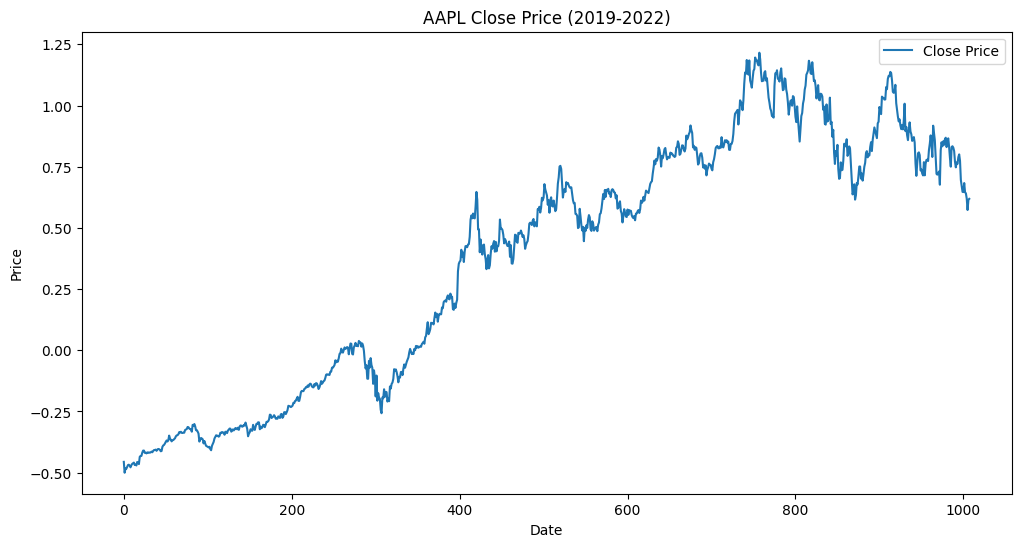

In [51]:
aapl = df[df["Ticker"] == "AAPL"]
plt.figure(figsize=(12, 6))
plt.plot(aapl.index, aapl['Close'], label='Close Price')
plt.title('AAPL Close Price (2019-2022)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
# scaled btw

In [52]:
dates = sorted(df1['Date'].unique())
val_graph_snapshots = []

for date in dates:
    x_t, y_t = get_features_for_date(df1, date, tickers, target_cols)
    val_graph_snapshots.append((x_t, y_t))

In [53]:
val_graphs = []

for x_t, y_t in val_graph_snapshots:
    graph = Data(x=x_t, edge_index=edge_index, y=y_t)
    val_graphs.append(graph)
val_graphs[0]

Data(x=[20, 5], edge_index=[2, 36], y=[20, 5])

In [54]:
from torch_geometric.nn import GATConv
import torch.nn as nn
import torch.nn.functional as F

class StockGAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=5, heads=32, dropout=0.3):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(hidden_channels * heads)

        self.gat2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(hidden_channels * heads)

        self.gat3 = GATConv(hidden_channels * heads, hidden_channels, heads=1)
        self.norm3 = nn.LayerNorm(hidden_channels)

        self.regressor = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels // 2, out_channels)
        )
        self.scale_factor = nn.Parameter(torch.ones(out_channels))
        self.scale_bias = nn.Parameter(torch.zeros(out_channels))


    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = self.norm1(x)

        x = F.elu(self.gat2(x, edge_index))
        x = self.norm2(x)

        x = F.elu(self.gat3(x, edge_index))
        x = self.norm3(x)

        out = self.regressor(x)
        return out * self.scale_factor + self.scale_bias

In [55]:
model = StockGAT(
    in_channels=len(target_cols),
    hidden_channels=128,
    out_channels=5,
    heads=32,
    dropout=0.3
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
loss_fn = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5)

In [56]:
train_loader = DataLoader(graphs, batch_size=64, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=64, shuffle=False)

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
edge_index = edge_index.to(device)
epochs = 100
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training", leave=False):
        batch = batch.to(device)

        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"[Epoch {epoch+1}] Validation", leave=False):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            loss = loss_fn(out, batch.y)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 1 | Train Loss: 0.6142 | Val Loss: 0.2878


Epoch 2 | Train Loss: 0.5212 | Val Loss: 0.3140


Epoch 3 | Train Loss: 0.4905 | Val Loss: 0.3083


Epoch 4 | Train Loss: 0.4565 | Val Loss: 0.2524


Epoch 5 | Train Loss: 0.4329 | Val Loss: 0.2023


Epoch 6 | Train Loss: 0.4162 | Val Loss: 0.1801


Epoch 7 | Train Loss: 0.4033 | Val Loss: 0.1802


Epoch 8 | Train Loss: 0.3925 | Val Loss: 0.1806


Epoch 9 | Train Loss: 0.3883 | Val Loss: 0.1780


Epoch 10 | Train Loss: 0.3843 | Val Loss: 0.1751


Epoch 11 | Train Loss: 0.3802 | Val Loss: 0.1733


Epoch 12 | Train Loss: 0.3779 | Val Loss: 0.1729


Epoch 13 | Train Loss: 0.3746 | Val Loss: 0.1725


Epoch 14 | Train Loss: 0.3679 | Val Loss: 0.1711


Epoch 15 | Train Loss: 0.3702 | Val Loss: 0.1712


Epoch 16 | Train Loss: 0.3674 | Val Loss: 0.1705


Epoch 17 | Train Loss: 0.3686 | Val Loss: 0.1709


Epoch 18 | Train Loss: 0.3652 | Val Loss: 0.1703


Epoch 19 | Train Loss: 0.3685 | Val Loss: 0.1703


Epoch 20 | Train Loss: 0.3600 | Val Loss: 0.1698


Epoch 21 | Train Loss: 0.3667 | Val Loss: 0.1705


Epoch 22 | Train Loss: 0.3668 | Val Loss: 0.1700


Epoch 23 | Train Loss: 0.3626 | Val Loss: 0.1704


Epoch 24 | Train Loss: 0.3630 | Val Loss: 0.1696


Epoch 25 | Train Loss: 0.3651 | Val Loss: 0.1700


Epoch 26 | Train Loss: 0.3609 | Val Loss: 0.1699


Epoch 27 | Train Loss: 0.3599 | Val Loss: 0.1709


Epoch 28 | Train Loss: 0.3585 | Val Loss: 0.1696


Epoch 29 | Train Loss: 0.3562 | Val Loss: 0.1703


Epoch 30 | Train Loss: 0.3583 | Val Loss: 0.1697


Epoch 31 | Train Loss: 0.3599 | Val Loss: 0.1698


Epoch 32 | Train Loss: 0.3577 | Val Loss: 0.1693


Epoch 33 | Train Loss: 0.3550 | Val Loss: 0.1697


Epoch 34 | Train Loss: 0.3564 | Val Loss: 0.1699


Epoch 35 | Train Loss: 0.3592 | Val Loss: 0.1694


Epoch 36 | Train Loss: 0.3562 | Val Loss: 0.1697


Epoch 37 | Train Loss: 0.3579 | Val Loss: 0.1695


Epoch 38 | Train Loss: 0.3585 | Val Loss: 0.1695


Epoch 39 | Train Loss: 0.3555 | Val Loss: 0.1694


Epoch 40 | Train Loss: 0.3578 | Val Loss: 0.1694


Epoch 41 | Train Loss: 0.3564 | Val Loss: 0.1695


Epoch 42 | Train Loss: 0.3557 | Val Loss: 0.1694


Epoch 43 | Train Loss: 0.3584 | Val Loss: 0.1694


Epoch 44 | Train Loss: 0.3564 | Val Loss: 0.1694


Epoch 45 | Train Loss: 0.3538 | Val Loss: 0.1696


Epoch 46 | Train Loss: 0.3544 | Val Loss: 0.1694


Epoch 47 | Train Loss: 0.3544 | Val Loss: 0.1694


Epoch 48 | Train Loss: 0.3544 | Val Loss: 0.1694


Epoch 49 | Train Loss: 0.3544 | Val Loss: 0.1693


Epoch 50 | Train Loss: 0.3533 | Val Loss: 0.1694


Epoch 51 | Train Loss: 0.3568 | Val Loss: 0.1694


Epoch 52 | Train Loss: 0.3558 | Val Loss: 0.1694


Epoch 53 | Train Loss: 0.3536 | Val Loss: 0.1695


Epoch 54 | Train Loss: 0.3551 | Val Loss: 0.1692


Epoch 55 | Train Loss: 0.3537 | Val Loss: 0.1692


Epoch 56 | Train Loss: 0.3526 | Val Loss: 0.1693


Epoch 57 | Train Loss: 0.3523 | Val Loss: 0.1693


Epoch 58 | Train Loss: 0.3554 | Val Loss: 0.1692


Epoch 59 | Train Loss: 0.3546 | Val Loss: 0.1693


Epoch 60 | Train Loss: 0.3572 | Val Loss: 0.1694


Epoch 61 | Train Loss: 0.3558 | Val Loss: 0.1694


Epoch 62 | Train Loss: 0.3531 | Val Loss: 0.1694


Epoch 63 | Train Loss: 0.3547 | Val Loss: 0.1694


Epoch 64 | Train Loss: 0.3521 | Val Loss: 0.1694


Epoch 65 | Train Loss: 0.3535 | Val Loss: 0.1694


Epoch 66 | Train Loss: 0.3544 | Val Loss: 0.1694


Epoch 67 | Train Loss: 0.3553 | Val Loss: 0.1694


Epoch 68 | Train Loss: 0.3525 | Val Loss: 0.1693


Epoch 69 | Train Loss: 0.3516 | Val Loss: 0.1693


Epoch 70 | Train Loss: 0.3551 | Val Loss: 0.1694


Epoch 71 | Train Loss: 0.3541 | Val Loss: 0.1695


Epoch 72 | Train Loss: 0.3550 | Val Loss: 0.1693


Epoch 73 | Train Loss: 0.3539 | Val Loss: 0.1694


Epoch 74 | Train Loss: 0.3532 | Val Loss: 0.1693


Epoch 75 | Train Loss: 0.3540 | Val Loss: 0.1694


Epoch 76 | Train Loss: 0.3542 | Val Loss: 0.1693


Epoch 77 | Train Loss: 0.3544 | Val Loss: 0.1694


Epoch 78 | Train Loss: 0.3524 | Val Loss: 0.1693


Epoch 79 | Train Loss: 0.3526 | Val Loss: 0.1693


Epoch 80 | Train Loss: 0.3543 | Val Loss: 0.1693


Epoch 81 | Train Loss: 0.3538 | Val Loss: 0.1693


Epoch 82 | Train Loss: 0.3514 | Val Loss: 0.1693


Epoch 83 | Train Loss: 0.3518 | Val Loss: 0.1693


Epoch 84 | Train Loss: 0.3526 | Val Loss: 0.1693


Epoch 85 | Train Loss: 0.3535 | Val Loss: 0.1694


Epoch 86 | Train Loss: 0.3546 | Val Loss: 0.1693


Epoch 87 | Train Loss: 0.3525 | Val Loss: 0.1692


Epoch 88 | Train Loss: 0.3542 | Val Loss: 0.1692


Epoch 89 | Train Loss: 0.3517 | Val Loss: 0.1694


Epoch 90 | Train Loss: 0.3504 | Val Loss: 0.1693


Epoch 91 | Train Loss: 0.3516 | Val Loss: 0.1693


Epoch 92 | Train Loss: 0.3527 | Val Loss: 0.1692


Epoch 93 | Train Loss: 0.3530 | Val Loss: 0.1693


Epoch 94 | Train Loss: 0.3522 | Val Loss: 0.1693


Epoch 95 | Train Loss: 0.3516 | Val Loss: 0.1694


Epoch 96 | Train Loss: 0.3515 | Val Loss: 0.1693


Epoch 97 | Train Loss: 0.3532 | Val Loss: 0.1693


Epoch 98 | Train Loss: 0.3526 | Val Loss: 0.1692


Epoch 99 | Train Loss: 0.3544 | Val Loss: 0.1694


Epoch 100 | Train Loss: 0.3525 | Val Loss: 0.1692


In [58]:
model.eval()
preds_list, actuals_list = [], []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Making Predictions", leave=False):
        batch = batch.to(device)
        preds = model(batch.x, batch.edge_index)

        preds_list.append(preds.cpu())
        actuals_list.append(batch.y.cpu())

In [59]:
import numpy as np

preds = torch.cat(preds_list, dim=0)
actuals = torch.cat(actuals_list, dim=0)

mask = actuals.abs().sum(dim=1) > 0

preds = preds[mask].numpy()
actuals = actuals[mask].numpy()

In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

preds = scaler.inverse_transform(preds)
actuals = scaler.inverse_transform(actuals)


mae = mean_absolute_error(actuals, preds)
rmse = np.sqrt(mean_squared_error(actuals, preds))
mape = np.mean(np.abs((actuals - preds) / actuals)) * 100
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

MAE: 1536059.8750, RMSE: 5974327.3693, MAPE: 37.07%


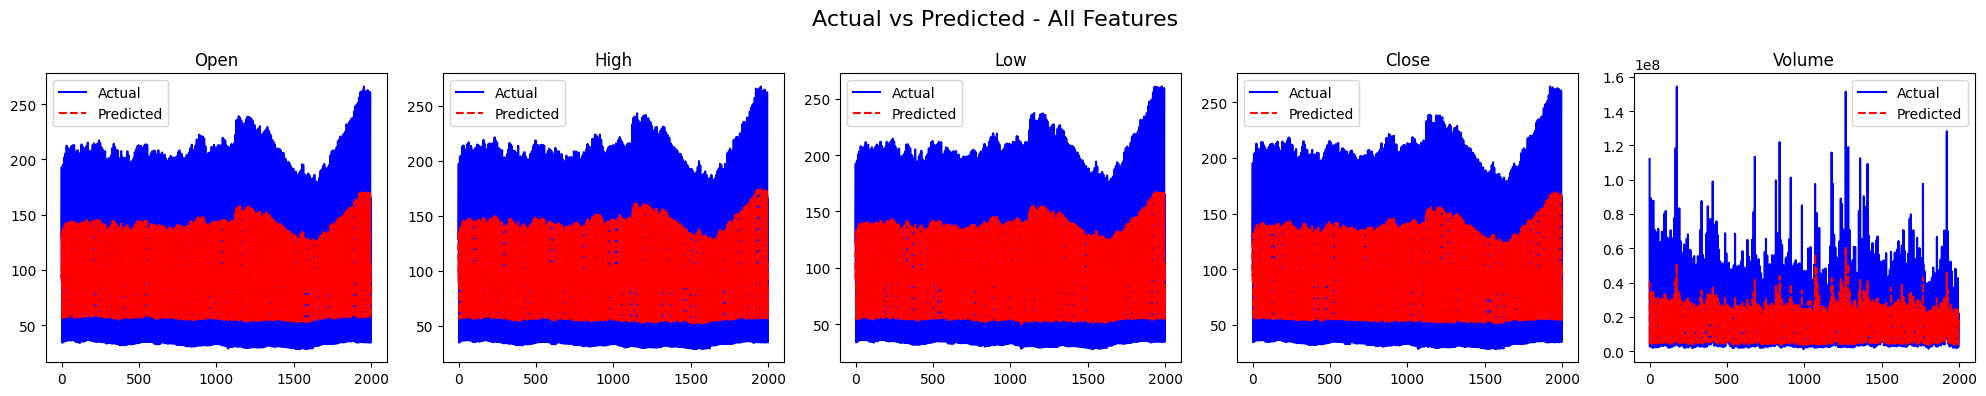

In [61]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharex=True)

column_names = ["Open", "High", "Low", "Close", "Volume"]
for i in range(5):
    axs[i].plot(actuals[:, i], label="Actual", color="blue")
    axs[i].plot(preds[:, i], label="Predicted", color="red", linestyle='dashed')
    axs[i].set_title(column_names[i])
    axs[i].legend()
fig.suptitle("Actual vs Predicted - All Features", fontsize=16)
plt.tight_layout()
plt.show()


## Classic ML

### What Models Were Used?  
We used a RandomForestRegressor from scikit-learn for classic regression modeling.  
This model was chosen to predict the target variable using tabular features that were engineered from the hypergraph structure.

### Why RandomForestRegressor?  
We chose RandomForest because:  
- Robust to Overfitting: The ensemble nature of the model helps avoid overfitting on the training data.  
- Handles Mixed Features Well: Performs well with heterogeneous inputs like sector info and moving averages.  
- No Need for Graph-Specific Pipelines: Allows seamless use of features from the hypergraph in a standard ML workflow.  
- Effective for Tabular Data: Especially suited for structured datasets without needing neural architectures.

---

### Implementation Overview  
#### Feature Engineering:  
- Extracted features from the hypergraph such as:  
  - Moving Averages over time windows  
  - Sector Averages based on hyperedge definitions  
- Combined these features into a consolidated dataframe  

#### Training Process:  
- The final dataframe was split into training and testing sets  
- A `RandomForestRegressor` model was initialized and trained on the training set  
- Predictions were generated on the test set  

#### Model Architecture:  
- Ensemble-based Tree Model: Combines multiple decision trees  
- Non-Linear Learning: Captures complex patterns in the data through aggregated decisions from many trees  


### Temporal Handling and Attention Mechanism  
- No Attention Mechanism: This classical model doesn’t use attention layers  
- Temporal Awareness via Feature Engineering:  
  - Used manually engineered features like moving averages to incorporate historical patterns  
  - Avoided explicit temporal models (like RNNs and Transformers) to keep the pipeline lightweight  

This approach gave us a strong baseline using interpretable, classical methods without the complexity of deep learning.

In [62]:
ticker_to_sector = {ticker: sector for sector, tickers in hyperedges.items() for ticker in tickers}

In [63]:
train_data = pd.read_csv('/content/DLG-Assignments/ASSignment2/train_stock_data.csv')
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data.sort_values(['Ticker', 'Date'], inplace=True)

In [64]:
clean_rows = [] # clean rows of data
for ticker in train_data['Ticker'].unique(): # go voer every unique ticker
    data = train_data[train_data['Ticker'] == ticker]
    valid_cols = data.columns[data.isna().sum() == 0]
    clean_rows.extend(data[valid_cols].values)

train_df = pd.DataFrame(clean_rows, columns=["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"])
train_df["Sector"] = train_df["Ticker"].map(ticker_to_sector) # ticker mapped to sector as a way to work with the hyperedges. we're considering it an attribute of each ticker itself
train_df = train_df.sort_values(["Ticker", "Date"]) # sort by ticker and date

In [65]:
# some feature engineeringl ike before
train_df["Return_1d"] = train_df.groupby("Ticker")["Open"].pct_change()
train_df["MA_5"] = train_df.groupby("Ticker")["Open"].transform(lambda x: x.rolling(5).mean())
train_df["MA_10"] = train_df.groupby("Ticker")["Open"].transform(lambda x: x.rolling(10).mean())
train_df["Volatility_5"] = train_df.groupby("Ticker")["Open"].transform(lambda x: x.rolling(5).std())

In [66]:
sector_return = train_df.groupby(["Date", "Sector"])["Return_1d"].mean().reset_index() # average one day return for each sector
sector_return.rename(columns={"Return_1d": "Sector_Avg_Return"}, inplace=True)
train_df = pd.merge(train_df, sector_return, on=["Date", "Sector"], how="left") # here we keep all the original rows from train_df. The merge keys we're using are date and sector

In [67]:
# now we create target columns for the next day's values by shifting the data forward
train_df["Target_Open"] = train_df.groupby("Ticker")["Open"].shift(-1)
train_df["Target_High"] = train_df.groupby("Ticker")["High"].shift(-1)
train_df["Target_Low"] = train_df.groupby("Ticker")["Low"].shift(-1)
train_df["Target_Close"] = train_df.groupby("Ticker")["Close"].shift(-1)
train_df["Target_Volume"] = train_df.groupby("Ticker")["Volume"].shift(-1)

In [68]:
val_data = pd.read_csv('/content/DLG-Assignments/ASSignment2/validation_stock_data.csv')
val_data['Date'] = pd.to_datetime(val_data['Date'])
val_data.sort_values(['Ticker', 'Date'], inplace=True)

In [69]:
# now we do with val data whatever we did with the train data
val_rows = []
for ticker in val_data['Ticker'].unique():
    data = val_data[val_data['Ticker'] == ticker]
    valid_cols = data.columns[data.isna().sum() == 0]
    val_rows.extend(data[valid_cols].values)

val_df = pd.DataFrame(val_rows, columns=["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"])
val_df["Sector"] = val_df["Ticker"].map(ticker_to_sector)
val_df = val_df.sort_values(["Ticker", "Date"])

In [70]:
val_df["Return_1d"] = val_df.groupby("Ticker")["Open"].pct_change()
val_df["MA_5"] = val_df.groupby("Ticker")["Open"].transform(lambda x: x.rolling(5).mean())
val_df["MA_10"] = val_df.groupby("Ticker")["Open"].transform(lambda x: x.rolling(10).mean())
val_df["Volatility_5"] = val_df.groupby("Ticker")["Open"].transform(lambda x: x.rolling(5).std())

In [71]:
combined = pd.concat([train_df, val_df])
combined["Date"] = pd.to_datetime(combined["Date"])
sector_return = combined.groupby(["Date", "Sector"])["Return_1d"].mean().reset_index()
sector_return.rename(columns={"Return_1d": "Sector_Avg_Return"}, inplace=True)
val_df = pd.merge(val_df, sector_return, on=["Date", "Sector"], how="left")

# Validation targets. everything after this is the same ML workflow of getting the
# targets, the features, and then model.fit()
val_df["Target_Open"] = val_df.groupby("Ticker")["Open"].shift(-1)
val_df["Target_High"] = val_df.groupby("Ticker")["High"].shift(-1)
val_df["Target_Low"] = val_df.groupby("Ticker")["Low"].shift(-1)
val_df["Target_Close"] = val_df.groupby("Ticker")["Close"].shift(-1)
val_df["Target_Volume"] = val_df.groupby("Ticker")["Volume"].shift(-1)

In [72]:
features = ["Return_1d", "MA_5", "MA_10", "Volatility_5", "Sector_Avg_Return"]
targets = ["Target_Open", "Target_High", "Target_Low", "Target_Close", "Target_Volume"]

In [73]:
train_df_model = train_df.dropna(subset=features + targets)
val_df_model = val_df.dropna(subset=features + targets)

X_train = train_df_model[features]
y_train = train_df_model[targets]

X_val = val_df_model[features]
y_val = val_df_model[targets]

In [75]:
base_model = RandomForestRegressor(n_estimators=100, random_state=42)
multi_model = MultiOutputRegressor(base_model)
multi_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

In [77]:
def evaluate_model(X, y_true, dataset_name=""):
    y_pred = multi_model.predict(X)
    print(f"\nEvaluation on {dataset_name}:")
    for i, target in enumerate(targets):
        rmse = mean_squared_error(y_true.iloc[:, i], y_pred[:, i])
        mape = mean_absolute_percentage_error(y_true.iloc[:, i], y_pred[:, i])
        print(f"{target}: RMSE = {rmse:.4f}, MAPE = {mape:.4f}")

evaluate_model(X_train, y_train, "TRAINING") # train
evaluate_model(X_val, y_val, "VALIDATION") # val


Evaluation on TRAINING:
Target_Open: RMSE = 1.3732, MAPE = 0.0062
Target_High: RMSE = 1.4632, MAPE = 0.0065
Target_Low: RMSE = 1.6284, MAPE = 0.0069
Target_Close: RMSE = 1.7882, MAPE = 0.0073
Target_Volume: RMSE = 120222881666603.8125, MAPE = 0.5104

Evaluation on VALIDATION:
Target_Open: RMSE = 5.9847, MAPE = 0.0133
Target_High: RMSE = 7.5311, MAPE = 0.0145
Target_Low: RMSE = 7.7565, MAPE = 0.0153
Target_Close: RMSE = 9.3164, MAPE = 0.0165
Target_Volume: RMSE = 406783192486090.2500, MAPE = 1.6407


In [78]:
def predict_test_cases(test_cases, full_data, model, feature_columns):
    # we don't want to mutate the original list
    updated_cases = deepcopy(test_cases)

    # just making sure it's a normal datetime object
    full_data["Date"] = pd.to_datetime(full_data["Date"])

    for case in updated_cases:
        ticker = case["ticker"]
        target_date = pd.to_datetime(case["date"])

        # Filter past data for that specific ticker
        ticker_data = full_data[full_data["Ticker"] == ticker].copy()
        ticker_data = ticker_data[ticker_data["Date"] < target_date].sort_values("Date")

        if ticker_data.empty:
            print(f"Not enough data for {ticker} before {target_date}")
            continue

        # we basically replicate our full training feature engineering here
        ticker_data["Return_1d"] = ticker_data["Open"].pct_change()
        ticker_data["MA_5"] = ticker_data["Open"].rolling(5).mean()
        ticker_data["MA_10"] = ticker_data["Open"].rolling(10).mean()
        ticker_data["Volatility_5"] = ticker_data["Open"].rolling(5).std()

        # Drop the nans cuz they'll be at the beginning due to rolling windows
        ticker_data = ticker_data.dropna(subset=feature_columns)

        if ticker_data.empty:
            print(f"Not enough data with features for {ticker} before {target_date}")
            continue

        # last row of features as input
        input_features = ticker_data.iloc[-1][feature_columns].values.reshape(1, -1)

        preds = model.predict(input_features)[0] # unpack what we have

        # now we'll map the predictions into the dict
        keys = ["predicted_open", "predicted_high", "predicted_low", "predicted_close", "predicted_volume"]
        for key, val in zip(keys, preds):
            case[key] = float(val)  # converting to float for json compatibility

    return updated_cases


In [ ]:
feature_columns = ['Return_1d', 'MA_5', 'MA_10', 'Volatility_5', 'Sector_Avg_Return']

updated_test_cases = predict_test_cases(
    test_cases=test_cases,
    full_data=train_df,   # we need to include past data for all tickers
    model=multi_model,  # our trained multi-target regression model
    feature_columns=feature_columns
)

In [80]:
with open("predictedFromTheBlind.json", "w") as f:
    json.dump(updated_test_cases, f, indent=4)